In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!source /content/drive/MyDrive/colab_env/bin/activate

In [3]:
import pickle
with open("/content/drive/MyDrive/WaterBalance_new/notebook/ds_array_4_mahdoode_mashhad.pkl", "rb") as f:
    ds_array_4 = pickle.load(f)

with open("/content/drive/MyDrive/WaterBalance_new/notebook/Ea_pyet_mahdoode_mashhad.pkl", "rb") as f:
    Ea_pyet = pickle.load(f)

Ea_pyet
ds_array_4

<xarray.Dataset>
Dimensions:             (time: 1, y: 13, x: 18)
Coordinates:
  * x                   (x) float32 58.35 58.45 58.55 ... 59.85 59.95 60.05
  * y                   (y) float32 37.05 36.95 36.85 ... 36.05 35.95 35.85
  * time                (time) datetime64[ns] 2022-01-31
    spatial_ref         int64 0
Data variables:
    precipitation       (time, y, x) float32 nan nan 0.0 0.0 ... nan nan nan nan
    runoff              (time, y, x) float64 nan nan 22.81 22.81 ... nan nan nan
    underground_runoff  (time, y, x) float64 nan nan 0.0 0.0 ... nan nan nan nan
    soilmoisture        (time, y, x) float32 nan nan 10.65 10.65 ... nan nan nan
    sub_soilmoisture    (time, y, x) float32 nan nan 35.37 35.37 ... nan nan nan
    shapefile           (y, x) float64 nan nan 0.0 0.0 0.0 ... nan nan nan nan
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

In [4]:
import os
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import geopandas as gpd
import ee
import wxee
import geemap
import rasterio
import rioxarray
import itertools


In [5]:
ee.Authenticate()
wxee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=gkSdg-FFEpXu6CD8miW8DgHAaE9Lovpt5edAUzjsIc4&tc=5V0c3A0Rt9JCPkcN2wxja8SFO52ypiBqP5wLCWC792A&cc=E1FPzm1AmqhbzD3aV6yYXnsu-j0A57eGv7zLKYlBIr4

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VOTCdoAn1beCvCAp3LpxxyTth1mCD9VqWA8AIg5gDBuCsY3oZS5K2E

Successfully saved authorization token.


In [9]:
# mashhad
LAT_MIN = 35.80
LAT_MAX = 37.11
LON_MIN = 58.31
LON_MAX = 60.14

PATH_DATA = "/content/drive/MyDrive/WaterBalance_new/assets/"

def mask_nc_file(
    nc,
    variable,
    lat_min,
    lat_max,
    lon_min,
    lon_max
):
    with xr.open_dataset(nc) as xr_nc:
        result = xr_nc.sel(
            lat = slice(lat_max, lat_min),
            lon = slice(lon_min, lon_max),
        )
    return result



# mm d-1 - precipitation
P = mask_nc_file(
    nc = PATH_DATA + "nc/P_2022031.nc",
    variable = "precipitation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)

P.rio.write_crs("epsg:4326", inplace=True)

p = P.rename({'lon': 'x','lat': 'y'})

In [34]:


shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])

runoff_sum = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filter(ee.Filter.date('2022-01-31', '2022-02-01')).select('runoff_sum').mean().clip(shape)
potential_evaporation_sum = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filter(ee.Filter.date('2022-06-15', '2022-06-16')).select('potential_evaporation_sum').sum().clip(shape)
runoff_sum_terra = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").filter(ee.Filter.date('2022-01-01', '2022-01-31')).select('ro').mean().clip(shape)
dataset = ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001').filter(ee.Filter.date('2022-01-01', '2022-01-31')).select('Qs_tavg').mean().clip(shape)
dataset_gldas = ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H").filter(ee.Filter.date('2022-01-01', '2022-01-31')).select('Qs_acc').sum().clip(shape)

runoff_sum = runoff_sum.set("system:time_start", ee.Date("2022-01-31"))
potential_evaporation_sum = potential_evaporation_sum.set("system:time_start", ee.Date("2022-06-15"))
runoff_sum_terra = runoff_sum_terra.set("system:time_start", ee.Date("2022-01-31"))
dataset = dataset.set("system:time_start", ee.Date("2022-01-31"))
dataset_gldas = dataset_gldas.set("system:time_start", ee.Date("2022-01-31"))

arr_runoff_sum = runoff_sum.wx.to_xarray(scale=11132, crs='EPSG:4326')
arr_potential_evaporation_sum = potential_evaporation_sum.wx.to_xarray(scale=11132, crs='EPSG:4326')
arr_runoff_sum_terra = runoff_sum_terra.wx.to_xarray(scale=4638.3, crs='EPSG:4326')
arr_dataset = dataset.wx.to_xarray(scale=11132, crs='EPSG:4326')
arr_dataset_gldas = dataset_gldas.wx.to_xarray(scale=27830, crs='EPSG:4326')

xds_repr_match_arr_runoff_sum = arr_runoff_sum.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match_arr_potential_evaporation_sum = arr_potential_evaporation_sum.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match_arr_runoff_sum_terra = arr_runoff_sum_terra.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match_arr_dataset = arr_dataset.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match_arr_dataset_gldas = arr_dataset_gldas.rio.reproject_match(p, resampling = rasterio.enums.Resampling.nearest)

xds_repr_match_arr_runoff_sum_1 = xds_repr_match_arr_runoff_sum * (1000)

xds_repr_match_arr_dataset = xds_repr_match_arr_dataset * 86400 * 30

xds_repr_match_arr_potential_evaporation_sum

Downloading:   0%|          | 0.00/1.94k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/2.30k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/1.98k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/1.44k [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:                    (x: 18, y: 13, time: 1)
Coordinates:
  * x                          (x) float32 58.35 58.45 58.55 ... 59.95 60.05
  * y                          (y) float32 37.05 36.95 36.85 ... 35.95 35.85
  * time                       (time) datetime64[ns] 2022-06-15
    spatial_ref                int64 0
Data variables:
    potential_evaporation_sum  (time, y, x) float64 -0.007036 ... -0.008676
Attributes:
    transform:               (0.10000045742818513, 0.0, 58.30026668063193, 0....
    crs:                     +init=epsg:4326
    res:                     (0.10000045742818513, 0.10000045742818513)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

ERA5

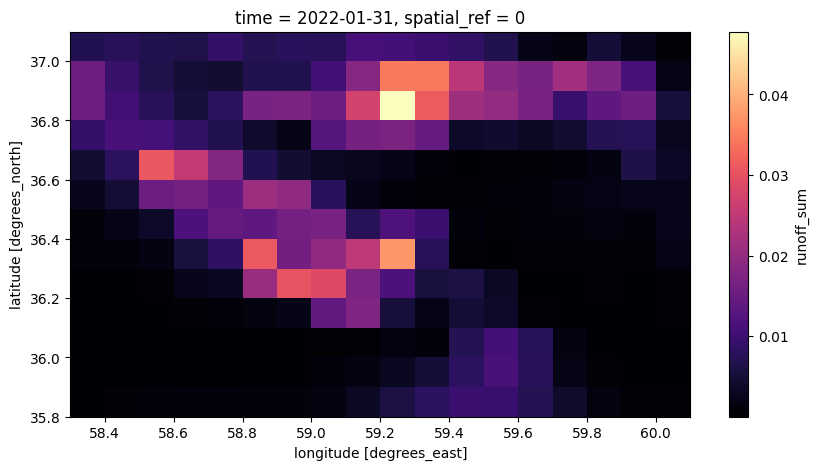

In [17]:
xds_repr_match_arr_runoff_sum_1.runoff_sum.plot(figsize=(10, 5), cmap="magma")

QDWB

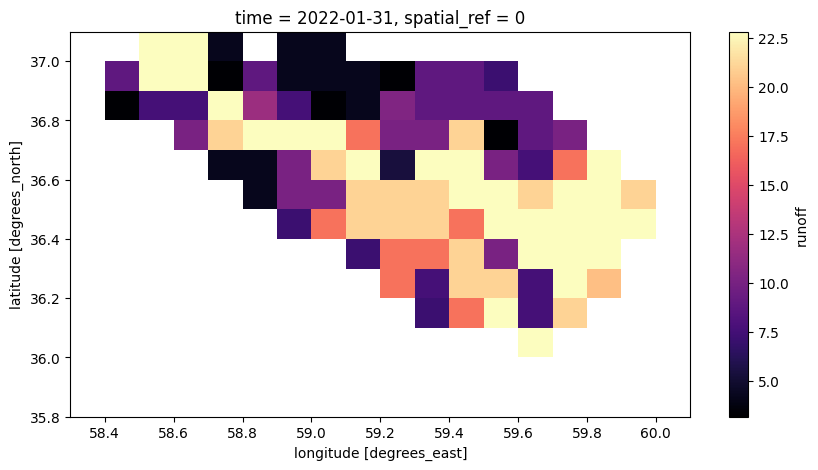

In [12]:
ds_array_4.runoff.plot(figsize=(10, 5), cmap="magma")

terra

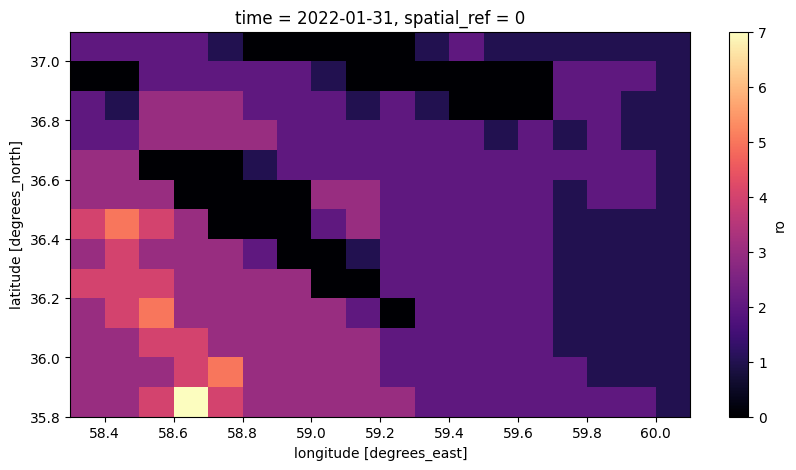

In [21]:
xds_repr_match_arr_runoff_sum_terra.ro.plot(figsize=(10, 5), cmap="magma")

FLDAS

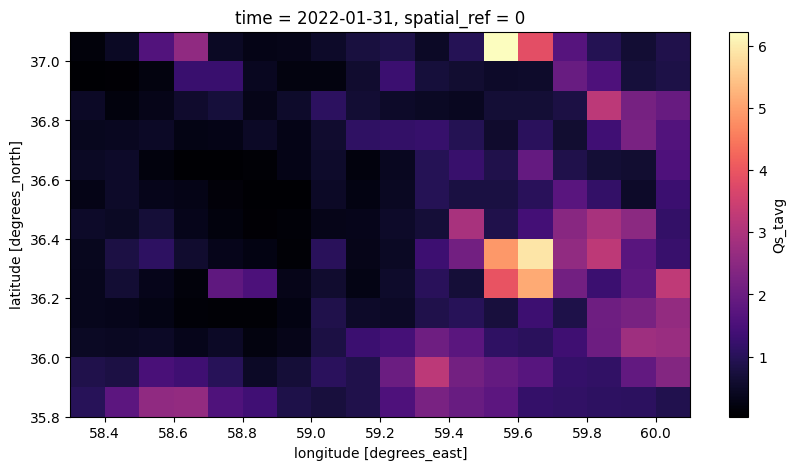

In [26]:
xds_repr_match_arr_dataset.Qs_tavg.plot(figsize=(10, 5), cmap="magma")

GLDAS

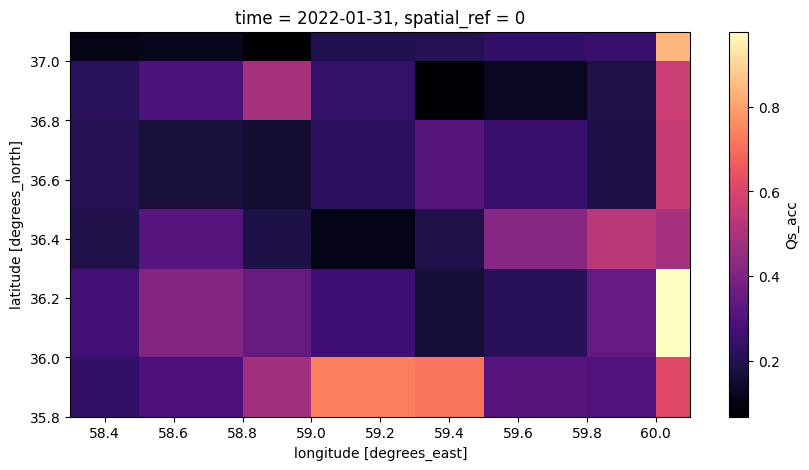

In [28]:
xds_repr_match_arr_dataset_gldas.Qs_acc.plot(figsize=(10, 5), cmap="magma")

evap erra

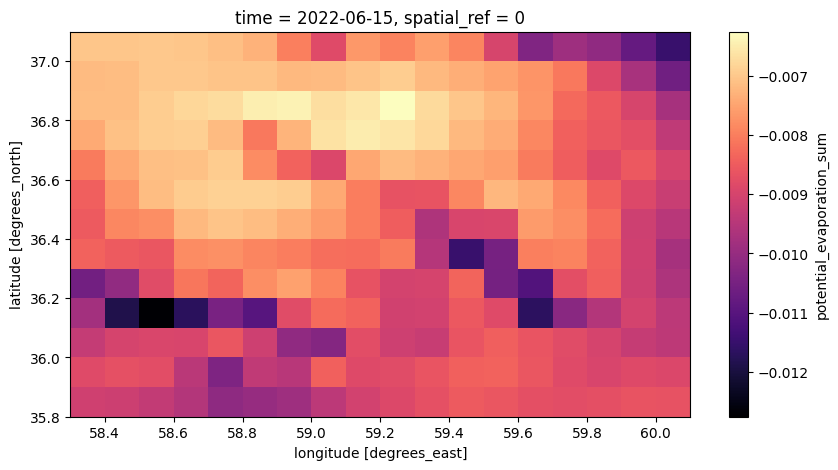

In [35]:
xds_repr_match_arr_potential_evaporation_sum.potential_evaporation_sum.plot(figsize=(10, 5), cmap="magma")